In [1]:
import torch
import torch.nn as nn
import json,  types, os
import torch.optim as optim
import torchvision 
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
#Configuración del dispositivo (GPU si está disponible, si no, CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


In [3]:
def get_data_loaders_from_folder(data_dir, batch_size=64, train_split_ratio=0.8):
    """
    Prepara y devuelve DataLoaders desde una carpeta local con subdirectorios por clase.
    """
    # Las transformaciones son muy importantes. Para tus propias imágenes,
    # es buena idea añadir un Resize para asegurar que todas tengan el mismo tamaño.
    transform = transforms.Compose([
        transforms.Resize((32, 32)), # Asegura que todas las imágenes sean de 32x32
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # 1. Cargar el dataset completo desde la carpeta raíz
    full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    
    # 2. Obtener los nombres de las clases
    classes = full_dataset.classes
    print(f"Clases encontradas: {classes}")

    # 3. Dividir el dataset en entrenamiento y prueba
    train_size = int(train_split_ratio * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    # 4. Crear los DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader, classes

In [4]:
def imshow(img, title=""):
    """Función para desnormalizar y mostrar una imagen."""
    img = img / 2 + 0.5  # Desnormalizar (revierte la normalización de -1 a 1)
    npimg = img.numpy()
    # Cambia el orden de los ejes de (Canales, Alto, Ancho) a (Alto, Ancho, Canales) para que matplotlib pueda mostrarla
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [5]:
class Autoencoder(nn.Module):
    """
    Un Autoencoder Convolucional.
    El tamaño del espacio latente es un parámetro clave para experimentar.
    """
    def __init__(self, latent_dim=64):
        super(Autoencoder, self).__init__()
        
        # --- Encoder ---
        # Entrada: 3 x 32 x 32
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # -> 16 x 32 x 32
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # -> 16 x 16 x 16
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # -> 32 x 16 x 16
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # -> 32 x 8 x 8
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # -> 64 x 8 x 8
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # -> 64 x 4 x 4
        )
        
        # Capa para aplanar y mapear al espacio latente
        self.to_latent = nn.Linear(64 * 4 * 4, latent_dim)
        
        # Capa para expandir desde el espacio latente
        self.from_latent = nn.Linear(latent_dim, 64 * 4 * 4)

        # --- Decoder ---
        # Es la arquitectura inversa del encoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), # -> 32 x 8 x 8
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2), # -> 16 x 16 x 16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2), # -> 3 x 32 x 32
            nn.Tanh() # Tanh es ideal porque la salida está normalizada entre -1 y 1
        )

    def forward(self, x):
        # Codificar
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1) # Aplanar
        latent_code = self.to_latent(encoded)
        
        # Decodificar
        reconstructed_flat = self.from_latent(latent_code)
        reconstructed_conv_input = reconstructed_flat.view(reconstructed_flat.size(0), 64, 4, 4)
        reconstructed_image = self.decoder(reconstructed_conv_input)
        
        return reconstructed_image, latent_code


In [6]:
def train_autoencoder(model, train_loader, num_epochs=20, learning_rate=1e-3):
    """
    Entrena el modelo Autoencoder.
    """
    model.to(device)
    criterion = nn.MSELoss() # Error Cuadrático Medio para la reconstrucción
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    print("--- Iniciando entrenamiento del Autoencoder ---")
    for epoch in range(num_epochs):
        total_loss = 0
        for data in train_loader:
            images, _ = data
            images = images.to(device)
            
            # Forward pass
            reconstructed, _ = model(images)
            loss = criterion(reconstructed, images)
            
            # Backward pass y optimización
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Pérdida de Reconstrucción: {avg_loss:.4f}')
    
    print("--- Entrenamiento del Autoencoder finalizado ---")


In [7]:
class ImageClassifier(nn.Module):
    """
    Clasificador que usa el encoder pre-entrenado.
    """
    def __init__(self, trained_encoder, latent_dim, num_classes):
        super(ImageClassifier, self).__init__()
        self.encoder = trained_encoder
        
        # Congelamos los pesos del encoder. ¡No queremos re-entrenarlo!
        for param in self.encoder.parameters():
            param.requires_grad = False
            
        # Capas de clasificación que se añadirán después del encoder
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5), # Dropout para regularizar y evitar sobreajuste
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # 1. Extraer características con el encoder congelado
        with torch.no_grad(): # Aseguramos que no se calculen gradientes para el encoder
            features = self.encoder(x)
            features = features.view(features.size(0), -1)
            # Nota: Aquí no pasamos por `to_latent` porque el encoder ya da una buena representación
            # Podríamos experimentar usando el `latent_code` también.
        
        # 2. Clasificar las características
        output = self.classifier(features)
        return output


In [8]:
def train_and_evaluate_classifier(model, train_loader, test_loader, classes, num_epochs=15, learning_rate=1e-3):
    """
    Entrena y evalúa el modelo clasificador.
    """
    model.to(device)
    criterion = nn.CrossEntropyLoss() # Pérdida para clasificación multi-clase
    # Solo optimizamos los parámetros del clasificador, no del encoder
    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
    
    print("\n--- Iniciando entrenamiento del Clasificador ---")
    for epoch in range(num_epochs):
        model.train() # Modo entrenamiento
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(f'Epoch [{epoch+1}/{num_epochs}], Pérdida de Clasificación: {loss.item():.4f}')

    print("--- Entrenamiento del Clasificador finalizado ---")
    
    # --- Evaluación del modelo ---
    print("\n--- Evaluando el modelo ---")
    model.eval() # Modo evaluación (desactiva dropout, etc.)
    all_preds = []
    all_labels = []
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy en el conjunto de prueba: {accuracy:.2f} %')
    
    # --- Reporte de clasificación y Matriz de Confusión ---
    print("\nReporte de Clasificación:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    print("Matriz de Confusión:")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    plt.show()


Clases encontradas: ['cpu', 'mesa', 'mouse', 'nada', 'pantalla', 'silla', 'teclado']
--- Iniciando entrenamiento del Autoencoder ---
Epoch [1/25], Pérdida de Reconstrucción: 0.3085
Epoch [2/25], Pérdida de Reconstrucción: 0.2792
Epoch [3/25], Pérdida de Reconstrucción: 0.2417
Epoch [4/25], Pérdida de Reconstrucción: 0.1931
Epoch [5/25], Pérdida de Reconstrucción: 0.1547
Epoch [6/25], Pérdida de Reconstrucción: 0.1347
Epoch [7/25], Pérdida de Reconstrucción: 0.1193
Epoch [8/25], Pérdida de Reconstrucción: 0.1051
Epoch [9/25], Pérdida de Reconstrucción: 0.0938
Epoch [10/25], Pérdida de Reconstrucción: 0.0863
Epoch [11/25], Pérdida de Reconstrucción: 0.0802
Epoch [12/25], Pérdida de Reconstrucción: 0.0739
Epoch [13/25], Pérdida de Reconstrucción: 0.0692
Epoch [14/25], Pérdida de Reconstrucción: 0.0653
Epoch [15/25], Pérdida de Reconstrucción: 0.0630
Epoch [16/25], Pérdida de Reconstrucción: 0.0598
Epoch [17/25], Pérdida de Reconstrucción: 0.0572
Epoch [18/25], Pérdida de Reconstrucción: 0

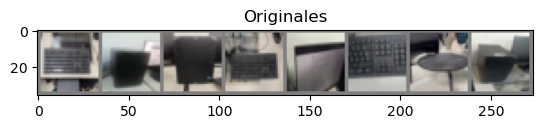

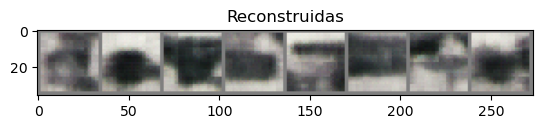


--- Iniciando entrenamiento del Clasificador ---
Epoch [1/20], Pérdida de Clasificación: 1.2539
Epoch [2/20], Pérdida de Clasificación: 1.2207
Epoch [3/20], Pérdida de Clasificación: 1.0331
Epoch [4/20], Pérdida de Clasificación: 0.6207
Epoch [5/20], Pérdida de Clasificación: 0.5181
Epoch [6/20], Pérdida de Clasificación: 0.8990
Epoch [7/20], Pérdida de Clasificación: 0.6729
Epoch [8/20], Pérdida de Clasificación: 0.2846
Epoch [9/20], Pérdida de Clasificación: 0.4169
Epoch [10/20], Pérdida de Clasificación: 0.3590
Epoch [11/20], Pérdida de Clasificación: 0.8803
Epoch [12/20], Pérdida de Clasificación: 0.4017
Epoch [13/20], Pérdida de Clasificación: 0.2249
Epoch [14/20], Pérdida de Clasificación: 0.4331
Epoch [15/20], Pérdida de Clasificación: 0.4613
Epoch [16/20], Pérdida de Clasificación: 0.2510
Epoch [17/20], Pérdida de Clasificación: 0.7530
Epoch [18/20], Pérdida de Clasificación: 0.2923
Epoch [19/20], Pérdida de Clasificación: 0.3821
Epoch [20/20], Pérdida de Clasificación: 0.3656

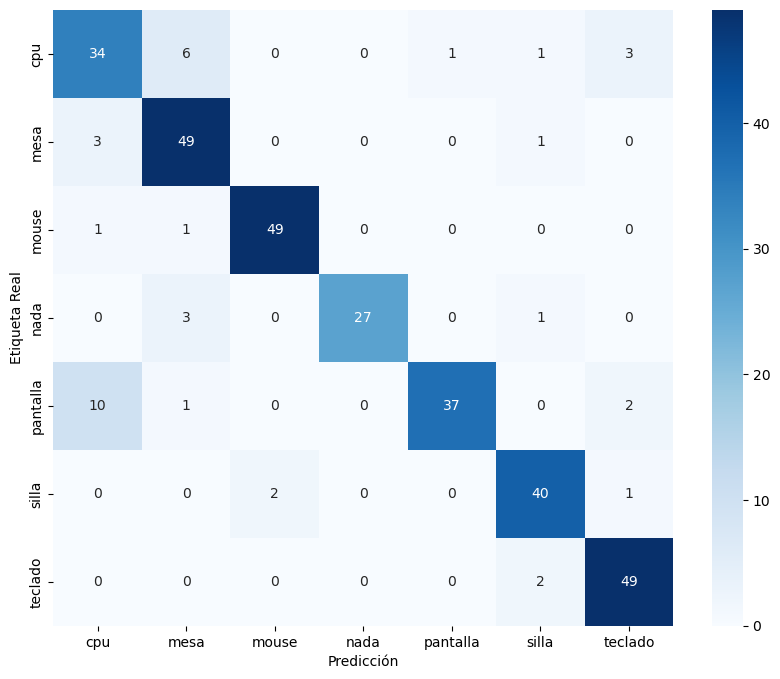

In [9]:
if __name__ == '__main__':
    # --- Parámetros para experimentar ---
    BATCH_SIZE = 128
    LATENT_DIM = 128  # Tamaño del cuello de botella. ¡Un parámetro clave!
    AE_EPOCHS = 25
    CLASSIFIER_EPOCHS = 20
    AE_LR = 1e-3
    CLASSIFIER_LR = 1e-3

    # 1. Cargar datos
    MY_DATASET_PATH = "objetos_salon/processed"

    # 1. Cargar datos desde tu carpeta local
    train_loader, test_loader, classes = get_data_loaders_from_folder(
        data_dir=MY_DATASET_PATH, 
        batch_size=BATCH_SIZE
    )
    
    
    # 2. Crear y entrenar el autoencoder
    autoencoder = Autoencoder(latent_dim=LATENT_DIM)
    train_autoencoder(autoencoder, train_loader, num_epochs=AE_EPOCHS, learning_rate=AE_LR)
    
    # Opcional: Visualizar reconstrucciones para ver qué tan bien aprendió el autoencoder
    dataiter = iter(test_loader)
    images, _ = next(dataiter)
    reconstructed, _ = autoencoder(images.to(device))
    imshow(torchvision.utils.make_grid(images[:8]), "Originales")
    imshow(torchvision.utils.make_grid(reconstructed[:8].cpu().detach()), "Reconstruidas")

    # 3. Extraer el encoder entrenado
    # Aquí es donde la modularidad brilla. Simplemente tomamos la parte que necesitamos.
    trained_encoder = autoencoder.encoder

    # 4. Crear, entrenar y evaluar el clasificador
    classifier = ImageClassifier(
        trained_encoder=trained_encoder,
        latent_dim=64 * 4 * 4, # Ajustar si cambias la arquitectura del encoder
        num_classes=len(classes)
    )
    train_and_evaluate_classifier(classifier, train_loader, test_loader, classes, num_epochs=CLASSIFIER_EPOCHS, learning_rate=CLASSIFIER_LR)


In [10]:
os.makedirs("export", exist_ok=True)

payload = {"meta": {}}

# Detectar y guardar Autoencoder (si existe)
if "autoencoder" in globals() and isinstance(autoencoder, torch.nn.Module):
    torch.save(autoencoder.state_dict(), "export/autoencoder_state.pt")
    payload["meta"]["has_autoencoder"] = True
else:
    payload["meta"]["has_autoencoder"] = False

# Detectar y guardar clasificador (si existe)
# Puede llamarse "classifier" o "model" según tu código
_classifier_obj = None
for name in ("classifier", "model", "clf"):
    if name in globals() and isinstance(globals()[name], torch.nn.Module):
        _classifier_obj = globals()[name]; break

if _classifier_obj is not None:
    torch.save(_classifier_obj.state_dict(), "export/classifier_state.pt")
    payload["meta"]["has_classifier"] = True
else:
    payload["meta"]["has_classifier"] = False

# Guardar clases si estaban definidas
for name in ("classes", "class_names"):
    if name in globals() and isinstance(globals()[name], (list, tuple)):
        payload["classes"] = list(globals()[name])
        break

# Guardar hiperparámetros mínimos útiles
payload["meta"]["input_size"] = [3, 224, 224]  # ajusta si usaste otro tamaño
payload["meta"]["framework"] = "pytorch"
payload["meta"]["notes"] = "Pesos guardados como state_dict. Cargar con la misma arquitectura."

with open("export/meta.json", "w", encoding="utf-8") as f:
    json.dump(payload, f, indent=2, ensure_ascii=False)

print("Exportación completa en carpeta ./export")
for fn in ("autoencoder_state.pt", "classifier_state.pt", "meta.json"):
    p = os.path.join("export", fn)
    if os.path.exists(p):
        print(" -", p)


Exportación completa en carpeta ./export
 - export/autoencoder_state.pt
 - export/classifier_state.pt
 - export/meta.json


In [11]:
#para cargarlo en otro notebook 
'''
# Carga (ejemplo mínimo)
import json, torch

with open("export/meta.json", "r", encoding="utf-8") as f:
    meta = json.load(f)

# Reconstruye tus clases/arquitecturas exactamente como en el notebook original:
# from tu_modulo import Autoencoder, ImageClassifier
# autoencoder = Autoencoder(...); classifier = ImageClassifier(...)

autoencoder.load_state_dict(torch.load("export/autoencoder_state.pt", map_location="cpu"))
# classifier.load_state_dict(torch.load("export/classifier_state.pt", map_location="cpu"))

autoencoder.eval()
# classifier.eval()

'''

'\n# Carga (ejemplo mínimo)\nimport json, torch\n\nwith open("export/meta.json", "r", encoding="utf-8") as f:\n    meta = json.load(f)\n\n# Reconstruye tus clases/arquitecturas exactamente como en el notebook original:\n# from tu_modulo import Autoencoder, ImageClassifier\n# autoencoder = Autoencoder(...); classifier = ImageClassifier(...)\n\nautoencoder.load_state_dict(torch.load("export/autoencoder_state.pt", map_location="cpu"))\n# classifier.load_state_dict(torch.load("export/classifier_state.pt", map_location="cpu"))\n\nautoencoder.eval()\n# classifier.eval()\n\n'